In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from data_loader import StockDataset
from model.GHATModel import GAT
from config import Config

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def build_adj():
    # connection = [
    # (1, 0),
    # (9, 0), (12, 0), 
    # (8, 9), (8, 12), (5, 9), (11, 12), 
    # (4, 5), (4, 8), (7, 8), (7, 11), (10, 11),
    # (3, 4), (3, 7), (6, 7), (6, 10), (2, 3), (2, 6)]
    
    # 无向图
    connection = [
        (1, 0), (0, 1),
        (9, 0), (12, 0), (0, 9), (0, 12),
        (8, 9), (8, 12), (5, 9), (11, 12), (9, 8), (12, 8), (9, 5), (12, 11),
        (4, 5), (4, 8), (7, 8), (7, 11), (10, 11), (5, 4), (8, 4), (8, 7), (11, 7), (11, 10),
        (3, 4), (3, 7), (6, 7), (6, 10), (2, 3), (2, 6), (4, 3), (7, 3), (7, 6), (10, 6), (3, 2), (6, 2)
        ]
    adj_matrix = torch.zeros(13, 13).float()
    for source, target in connection:
        adj_matrix[source][target] = 1
    return adj_matrix

large_market_cap_stocks = [
    "000951", "002841", "300133", "300343", "000998", "300433",
    "601021", "603197", "300166", "600026", "000998", "600171",
    "300917", "603087", "002309", "300451", "002549", "603466"
]

medium_market_cap_stocks = [
    "300540", "603359", "000046", "300263", "002679", "603053",
    "000403", "603306", "600970", "002703", "000931", "002186",
    "300633", "603195", "300133", "600360", "600729", "603777"
]

small_market_cap_stocks = [
    "300174", "603095", "000753", "600622", "002282", "002882",
    "300912", "603926", "002451", "002672", "000551", "300758",
    "001207", "300865", "002247", "002379", "300389", "300491"
]
market_cap = {'large': large_market_cap_stocks, 'medium': medium_market_cap_stocks, 'small': small_market_cap_stocks}

# 高流动股票代码列表（前六位）
high_flow_stocks = [
    "300133", "300343", "000046", "300263", "000753", "600622", 
    "300166", "600026", "600970", "002703", "002451", "002672", 
    "002309", "300451", "300133", "600360", "002247", "002379"
]

# 中流动股票代码列表（前六位）
medium_flow_stocks = [
    "000998", "300433", "002679", "603053", "002282", "002882", 
    "000998", "600171", "000931", "002186", "000551", "300758", 
    "002549", "603466", "600729", "603777", "300389", "300491"
]

# 低流动股票代码列表（前六位）
low_flow_stocks = [
    "000951", "002841", "300540", "603359", "300174", "603095", 
    "601021", "603197", "000403", "603306", "300912", "603926", 
    "300917", "603087", "300633", "603195", "001207", "300865"
]
flow_dict = {'high': high_flow_stocks, 'medium': medium_flow_stocks, 'low': low_flow_stocks}

# test

In [53]:
pred_dir = './pred/'
scaler_dir = './data/volume/0308/Scaler/'

for path in os.listdir(pred_dir):
    if path.endswith('.csv'):
        date_suffix = path[-10:-4]
        scaler_path = os.path.join(scaler_dir, f'{date_suffix}.m')
        
        stand = joblib.load(scaler_path)
        data = pd.read_csv(os.path.join(pred_dir, path))
        
        data.iloc[:, 0] = stand.transform(data.iloc[:, 0].values.reshape(-1, 1)).flatten().astype(float)
        data.iloc[:, 1] = stand.transform(data.iloc[:, 1].values.reshape(-1, 1)).flatten().astype(float)
        
        aps_value = np.abs(data.iloc[:, 0] - data.iloc[:, 1])
        mape = np.mean(aps_value/data.iloc[:, 1])
        # mean_difference = np.mean(np.abs(data.iloc[:, 0] - data.iloc[:, 1])/data.iloc[:, 1])
        print(f"{path} com is {mape}")

model_pred_300263.csv com is 0.935416413980514
model_pred_002882.csv com is 1.550863929888626
model_pred_002841.csv com is -1.0267474556341747
model_pred_002282.csv com is 3.756918435396213
model_pred_300174.csv com is -0.4021384301654137
model_pred_000998.csv com is -0.12983024485678749
model_pred_000951.csv com is -1.3434334328673543
model_pred_000046.csv com is -0.46476788085150367
model_pred_300133.csv com is 0.8758025108458504
model_pred_000753.csv com is 1.9249466546347918


# Analysis Tensorboard

save_models/saved_models-64-0.2-MSELoss/000951/scalar 558.3517 0.0579

save_models/saved_models-128-0.1-L1Loss/002882/scalar 0.6444 0.111  

save_models/saved_models-32-0.1-L1Loss/000951/scalar  0.3645  0.1776

save_models/saved_models-128-0.3-L1Loss/300263/scalar 5.4386  0.2057

save_models/saved_models-32-0.1-L1Loss/300174/scalar  0.6048  0.2104  

save_models/saved_models-128-0.1-L1Loss/000046/scalar  0.3891  0.215

save_models/saved_models-32-0.1-L1Loss/300133/scalar 0.4245 0.2317

save_models/saved_models-128-0.1-L1Loss/000753/scalar  1.1202  0.2362

save_models/saved_models-32-0.1-L1Loss/000753/scalar  0.6045 0.2512

save_models/saved_models-128-0.1-L1Loss/002841/scalar  0.4857  0.461

In [45]:
model_path = pd.read_excel('./model.xlsx')
path_dict = {}
for path in model_path['path']:
    for _ in os.listdir(path.split('/scalar')[0]):
        if 'train' in _ and '.tar' not in _:
            pt_path = os.path.join(path, _).replace('/scalar', '')
            pt_path = f"./{pt_path}"
            pred_path = f'./pred/model_pred_{_[:6]}.csv'
            data_path = f'./data/volume/0308/Input/{_[:6]}_3_3_inputs.npy'
            path_dict[_[:6]] = [pt_path, data_path, pred_path]

for key, value in path_dict.items():
    pt_path, data_path, pred_path = value[0], value[1], value[2]
    
    # load data
    data = np.load(data_path, allow_pickle= True)
    data = np.array([value[_] for item in data for value in item for _ in [0, 1, 2, 3, 4, 5, 6, 7, 8]], dtype= np.float32).reshape(data.shape[0], 13, 9)
    data = torch.from_numpy(data).to(device)

    # load model
    model = GAT(n_feat= len([0, 1, 2, 3, 4, 5, 6, 7, 8]), n_hid= 16, out_features= len([1]), 
                pred_length= 1, n_heads= 4)
    model = model.to(device= device)

    state_dict = torch.load(pt_path)
    model.load_state_dict(state_dict)
    model.eval()

    # model pred
    model_pred = model(data, build_adj())
    model_pred = model_pred.cpu().detach().numpy()

    # to csv
    pred_data = pd.read_csv(pred_path)
    pred_data[f'{key}-pred'] = model_pred
    pred_data.to_csv(f'./result/{key}.csv', index= None)

    # com model performance
    non_zero_mask = pred_data[f'{key}-true'] != 0
    mape = np.mean(np.abs((pred_data[f'{key}-true'][non_zero_mask]- pred_data[f'{key}-pred'][non_zero_mask])/ pred_data[f'{key}-true'][non_zero_mask]))
    # mape = np.mean(np.abs((pred_data[f'{key}-true']- pred_data[f'{key}-pred'])/ (pred_data[f'{key}-true']+ 1e-8)))
    mae = np.mean(pred_data[f'{key}-true']- pred_data[f'{key}-pred'])
    mse = np.mean((pred_data[f'{key}-true']- pred_data[f'{key}-pred'])** 2)

    print(f"{key} com MAE is {mae}, the MAPE is {mape}, the MSE is {mse}")

000951 com MAE is 0.17173053386621098, the MAPE is 2.518633466308861, the MSE is 0.5221717812411385
002882 com MAE is 0.12423068589359212, the MAPE is 2.1046718006878993, the MSE is 0.26982633313342996
300263 com MAE is 0.3505307760632711, the MAPE is 3.1935994183582874, the MSE is 0.6466603122536327
300174 com MAE is 0.2546607789525313, the MAPE is 2.1168768878390187, the MSE is 0.7743779097974093
000046 com MAE is 0.14571692178444937, the MAPE is 2.8024512486183615, the MSE is 0.46706784226470577
300133 com MAE is 0.4677060045788819, the MAPE is 6.006919753169601, the MSE is 0.8068875438268603
000753 com MAE is 0.3408899679655601, the MAPE is 4.5000158535369925, the MSE is 0.997200295958236
002841 com MAE is 0.3678779471036437, the MAPE is 4.670743773679899, the MSE is 0.7112576372651055
000998 com MAE is 0.11683616764812571, the MAPE is 2.3214763711409097, the MSE is 0.39026816087632676


| stock |  MAE   | MAPE | MSE  |
| :--:  | :--:   | :--: | :--: |
| 000046 | 0.067 | 2.784| 0.444|
| 002882 | 0.094 | 4.669| 0.710|
| 000951 | 0.194 | 2.633| 0.568|
| 300263 | 0.330 | 2.967| 0.609|
| 300174 | 0.229 | 2.031| 0.746|
| 300133 | 0.430 | 5.966| 0.785|
| 000753 | 0.357 | 4.565| 1.047|
| 002841 | 0.369 | 4.688| 0.713|
| 000998 | 0.091 | 2.411| 0.367|

In [46]:
result = './end_result/'
for data_path in os.listdir(result):
    pred_data = pd.read_csv(f'{result}{data_path}')
    key = data_path.split('.csv')[0]
    # com model performance
    non_zero_mask = pred_data[f'{key}-true'] != 0
    mape = np.mean(np.abs((pred_data[f'{key}-true'][non_zero_mask]- pred_data[f'{key}-pred'][non_zero_mask])/ (pred_data[f'{key}-true'][non_zero_mask])))
    mae = np.mean(pred_data[f'{key}-true']- pred_data[f'{key}-pred'])
    mse = np.mean((pred_data[f'{key}-true']- pred_data[f'{key}-pred'])** 2)

    print(f"{key} com MAE is {mae}, the MAPE is {mape}, the MSE is {mse}")

000753 com MAE is 0.3568296744179487, the MAPE is 4.565257975045892, the MSE is 1.0468893311222307
300263 com MAE is 0.3301482182794872, the MAPE is 2.966666300469162, the MSE is 0.6086557043995929
000998 com MAE is 0.0915205719877487, the MAPE is 2.4114674667919633, the MSE is 0.36674533100505274
000951 com MAE is 0.19498004116868423, the MAPE is 2.6327771803610047, the MSE is 0.5684222432400793
300133 com MAE is 0.4397617898415026, the MAPE is 5.966244515032575, the MSE is 0.7851925197273011
000046 com MAE is 0.06712500368747397, the MAPE is 2.7842108061709787, the MSE is 0.4440601307134777
002882 com MAE is 0.09368558017979427, the MAPE is 2.097611695986554, the MSE is 0.3116063670139982
002841 com MAE is 0.3670204628341969, the MAPE is 4.669078104983375, the MSE is 0.7103900892096832
300174 com MAE is 0.22933013198451282, the MAPE is 2.030887703447141, the MSE is 0.7463646253501821


In [7]:
path_dir = './data/0308/0308-data/'
path_list = os.listdir(path_dir)
for path in path_list:
    test = pd.read_csv(f'{path_dir}{path}')
    corr_value = test.iloc[:, 1:].corr()
    print(f'{path} the corr is {corr_value.iloc[0, 4]}')

300433_XSHE_25_daily.csv the corr is -0.05018412780538093
000951_XSHE_25_daily.csv the corr is 0.006499070456356722
000046_XSHE_25_daily.csv the corr is -0.025292199108096332
000998_XSHE_25_daily.csv the corr is -0.06417301369701807
002679_XSHE_25_daily.csv the corr is -0.04395794009055617
300263_XSHE_25_daily.csv the corr is -0.044277313292397036
300540_XSHE_25_daily.csv the corr is 0.01619292344657734
603053_XSHG_25_daily.csv the corr is -0.03826706361246143
600622_XSHG_25_daily.csv the corr is -0.02819947489846059
300174_XSHE_25_daily.csv the corr is -0.03089981921673612
002882_XSHE_25_daily.csv the corr is -0.024562945968328902
000753_XSHE_25_daily.csv the corr is -0.012347011070974035
603359_XSHG_25_daily.csv the corr is -0.007381870227684722
300133_XSHE_25_daily.csv the corr is -0.023778421675317782
002282_XSHE_25_daily.csv the corr is -0.015833455705401456
002841_XSHE_25_daily.csv the corr is -0.02189742569235223
300343_XSHE_25_daily.csv the corr is -0.026467016324222114
603095_

# Analysis

In [13]:
data_low = pd.read_csv('./data/0308/0308-data/000046_XSHE_25_daily.csv')
data_medium = pd.read_csv('./data/0308/0308-data/002882_XSHE_25_daily.csv')
data_heigh = pd.read_csv('./data/0308/0308-data/000998_XSHE_25_daily.csv')
data_analysis = {'low': data_low, 'medium': data_medium, 'heigh': data_heigh}

In [20]:
def plot_bbox(data_dict: dict):
    fig, axes = plt.subplots(nrows=1, ncols=len(data_dict), figsize=(12, 5))
    for i, (key, value) in enumerate(data_dict.items()):
        sns.boxplot(value['daily_volume'], ax= axes[i])
        axes[i].set_xlabel(f'{key}')
        axes[i].set_ylabel('daily_volume')
    # 调整子图之间的间距
    plt.tight_layout()
    # 显示图表
    plt.show()

def com_return(path_dir: str):
    path_list = os.listdir(path_dir)
    with tqdm(total=len(path_list)) as pbar:
        for path in path_list:
            file_path = os.path.join(path_dir, path)
            data = pd.read_excel(file_path)
            # data['收益率'] = data['收盘点位'].pct_change()
            data['日收益率'] = (data['收盘价'] - data['昨收价']) / data['昨收价'] * 100
            data = data.dropna()

            data.to_excel(f"./StockData/{path.split('.')[0]}.xlsx")
            pbar.update(1)

def com_stock_return(file_path_target: str, file_path_all: str):
    market_dict = {}
    for root, dirs, files in os.walk(file_path_target):
        for file in files:
            if file.endswith('.csv'):
                target_path = os.path.join(root, file)
                test1 = pd.read_csv(target_path)
                end, start = str(test1['time'].max())[:8], str(test1['time'].min())[:8]
                end, start = int(end), int(start)

                stock_info = target_path.split('_')[1][-6:]

                # get com return data path
                if os.path.exists(os.path.join(file_path_all, f"{stock_info}.SZ.xls")):
                    path_used = os.path.join(file_path_all, f"{stock_info}.SZ.xls")
                else:
                    path_used = os.path.join(file_path_all, f"{stock_info}.SH.xls")

                # open file
                try:
                    df = pd.read_excel(path_used)

                    # com daily_return and yead_return
                    daily_return = (df['收盘价'] - df['昨收价']) / df['昨收价'] * 100
                    year_return = daily_return.std()* np.sqrt(252)
                    # print(f"The {stock_info} Annualized Volatility {year_return}")
                    market_dict[stock_info] = year_return
                except Exception:
                    continue
    return market_dict

# plot_bbox(data_dict= data_analysis)
# com_return(path_dir= './stockData/allstock/')


market_return = com_stock_return(file_path_target= './data/raw_data/', file_path_all= './stockData/allstock/')

In [21]:
market_return

{'000403': 83.94171399855212,
 '600171': 49.431082769848935,
 '000551': 46.50375391336568,
 '002703': 246.06839649718341,
 '000998': 68.47825078391368,
 '002672': 41.42633479227145,
 '600026': 49.93037604196431,
 '000931': 711.7914954246801,
 '600970': 59.77701983835026,
 '603306': 49.6107296401739,
 '002186': 88.21341202517382,
 '300758': 66.66853128226039,
 '601021': 46.600327475973614,
 '300166': 58.26820108949775,
 '603197': 58.51819068581007,
 '603926': 48.08719028720553,
 '002451': 59.7939809524463,
 '300633': 58.063514324622176,
 '300389': 57.66784187527512,
 '600360': 64.38524516755488,
 '600729': 40.57379679498191,
 '603195': 87.85985838233813,
 '002247': 50.5248307861731,
 '002379': 50.15308049963824,
 '603466': 59.71602967430237,
 '300451': 68.05646239340707,
 '002309': 44.45894984085891,
 '300491': 66.12479336938773,
 '300133': 53.877745104515355,
 '603777': 59.42841792615807,
 '603087': 181.59597335111425,
 '002549': 50.55504593970418,
 '300433': 61.93785048792762,
 '00095

In [5]:
from pandas import DataFrame
import pandas as pd
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
def pad_to_shape(matrix, target_shape=(24, 7)):
    # 获取当前矩阵的形状
    current_shape = matrix.shape
    
    # 计算在每个维度上需要添加多少个0
    padding = [(max(0, ts - cs), 0) for cs, ts in zip(current_shape, target_shape)]
    
    # 使用np.pad进行填充，'constant'表示用常数进行填充，默认为0
    padded_matrix = np.pad(matrix, padding, mode='constant')
    
    return padded_matrix

def convert_string(s):
    s = s.strip("[]' ")
    return ast.literal_eval(s)

def convert_string_to_list(data: pd.DataFrame, time_length: int=6, bin_length: int=4, padding: str=True):
    tmp_list = []
    for item in data.values:
        for value in item:
            tmp_list.append(list(convert_string(value)))
    tmp_list = np.array(tmp_list, dtype=np.float32)
    
    # if tmp_list.shape[0] < time_length * bin_length and padding:
    #     tmp_list = pad_to_shape(tmp_list, target_shape=(time_length * bin_length, 7))
    return tmp_list

def build_training_data(input_path: str, time_length: int=6, bin_length: int=4, pred_length: int=1, way: str='None'):
    data = pd.read_csv(input_path).iloc[:, 1:]
    
    train_features = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    gnn_data, lstm_data, target_data = [], [], []
    
    # 构建输入数据
    for i in range(time_length, data.shape[0], 1):  # 行
        for j in range(bin_length, data.shape[1]-pred_length):  # 列
            if j < bin_length:
                tmp_matrix = convert_string_to_list(data.iloc[i-time_length:i, :j+1], padding= True)
            else:
                tmp_matrix = convert_string_to_list(data.iloc[i-time_length:i, j-bin_length:j], padding= True)
            
            gnn_data.append(tmp_matrix)

            lstm_data_tmp = pd.concat([data.iloc[i-2, j:data.shape[1]], data.iloc[i-1, :j]], axis=0)
            for value in lstm_data_tmp:
                lstm_data.append(convert_string(value))

            # lstm_data.append(pd.concat([data.iloc[i-2, j:data.shape[1]], data.iloc[i-1, :j]], axis=0).values)
            target_data.append(convert_string(data.iloc[i-1, j]))

    # 将 lstm_data 转换为 NumPy 数组
    gnn_data = np.array(gnn_data, dtype= np.float32)
    lstm_data = np.array(lstm_data, dtype=np.float32)
    lstm_data.resize((gnn_data.shape))
    target_data = np.array(target_data, dtype= np.float32)

    return gnn_data, lstm_data, target_data

class StockDataDataset(Dataset):
    def __init__(self,
                gnn_data: np.array,
                lstm_data: np.array,
                target_data: np.array,
                train_features: list= [0, 1, 2, 3, 4, 5, 6, 7, 8],
                pred_features: list= [0, 1, 2, 3, 4, 5, 6, 7, 8]):
        super().__init__()
        # data
        self.gnn_data = gnn_data
        self.lstm_data = lstm_data
        self.target_data = target_data

        # data features
        self.train_features = train_features
        self.pred_features = pred_features
    
    def __len__(self):
        return self.gnn_data.shape[0]

    def __getitem__(self, index):
        """
        先去把数据按照顺序切分好,然后根据index去找到切片
        """
        return self.gnn_data[index], self.lstm_data[index], self.target_data[index]

def gen_adjmatrix(time_length: int = 6, bin_length: int = 4, direct: bool = False) -> np.ndarray:
    num_nodes = time_length * bin_length
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for i in range(num_nodes):
        row, col = divmod(i, bin_length)
        # 右侧邻居
        if col < bin_length - 1:
            right_neighbor = i + 1
            adjacency_matrix[i, right_neighbor] = 1
            if not direct:
                adjacency_matrix[right_neighbor, i] = 1
        # 下方邻居
        if row < time_length - 1:
            bottom_neighbor = i + bin_length
            adjacency_matrix[i, bottom_neighbor] = 1
            if not direct:
                adjacency_matrix[bottom_neighbor, i] = 1
    return adjacency_matrix

def draw_grid_with_features(adjacency_matrix, time_length, bin_length, features, feature_index=0):
    G = nx.DiGraph() if np.any(adjacency_matrix != adjacency_matrix.T) else nx.Graph()
    num_nodes = time_length * bin_length
    G.add_nodes_from(range(num_nodes))

    # 添加边
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i, j] == 1:
                G.add_edge(i, j)

    # 设置布局
    pos = {i: (i % bin_length, time_length - 1 - i // bin_length) for i in range(num_nodes)}
    
    # 绘制图，并在节点上显示选定的特征值
    plt.figure(figsize=(8, 6))
    labels = {i: f'{i}\n{features[i, feature_index]:.2f}' for i in range(num_nodes)}  # 创建带有选定特征值的标签
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=10, edge_color='gray', arrowsize=20, arrowstyle='-|>', connectionstyle='arc3,rad=0.1', labels=labels)
    plt.title('6x4 Grid Graph with Selected Feature')
    plt.show()

gnn_data, lstm_data, target_data = build_training_data(input_path= './data/volume/0308/Features/000046_25_daily_f_all.csv')
data = pd.read_csv('./data/volume/0308/Features/000046_25_daily_f_all.csv')

In [26]:
data.iloc[:10, :10]

,date,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9
0,2020-05-13,"[-0.1641, -0.1641, -0.1641, 0.0188, -0.1641, -...","[-0.3463, -0.5104, -0.2552, 0.0397, -0.3463, -...","[-0.5711, -1.0815, -0.3605, 0.0654, -0.5711, -...","[-0.6848, -1.7662, -0.5341, 0.0785, -0.6848, -...","[-0.5939, -2.3601, -0.6166, 0.068, -0.5939, -0...","[-0.2299, -2.59, -0.5028, 0.0263, -0.2299, -0....","[-0.6891, -3.279, -0.5043, 0.079, -0.6891, -0....","[-0.4613, -3.7404, -0.4601, 0.0529, -0.4613, -...","[-0.5676, -4.3079, -0.5727, 0.065, -0.5676, -0..."
1,2020-05-14,"[-0.5371, -0.5371, -0.5371, 0.0378, -0.1641, -...","[-0.3869, -0.924, -0.462, 0.0403, -0.3463, -0....","[-0.5183, -1.4423, -0.4808, 0.0601, -0.5711, -...","[0.3645, -1.0778, -0.1802, 0.02, -0.6848, -0.1...","[0.1882, -0.8895, 0.0115, 0.0241, -0.5939, -0....","[-0.7078, -1.5974, -0.0517, 0.0506, -0.2299, -...","[-0.5059, -2.1033, -0.3418, 0.0662, -0.6891, -...","[-0.7217, -2.825, -0.6451, 0.0646, -0.4613, -0...","[-0.641, -3.466, -0.6229, 0.0664, -0.5676, -0...."
2,2020-05-15,"[1.5194, 1.5194, 1.5194, -0.0248, -0.1641, -0....","[-0.4838, 1.0357, 0.5178, 0.0428, -0.3463, -0....","[-0.497, 0.5387, 0.1796, 0.0564, -0.5711, -0.2...","[-0.6788, -0.1401, -0.5532, 0.0356, -0.6848, -...","[-0.738, -0.8782, -0.6379, 0.0403, -0.5939, -0...","[-0.7189, -1.597, -0.7119, 0.0574, -0.2299, -0...","[-0.6354, -2.2324, -0.6974, 0.0651, -0.6891, -...","[-0.7486, -2.9811, -0.701, 0.0677, -0.4613, -0...","[-0.7604, -3.7415, -0.7148, 0.0693, -0.5676, -..."
3,2020-05-18,"[-0.0519, -0.0519, -0.0519, -0.0292, -0.1641, ...","[0.1828, 0.1309, 0.0654, 0.023, -0.3463, -0.20...","[-0.2728, -0.1419, -0.0473, 0.0444, -0.5711, -...","[-0.6236, -0.7655, -0.2379, 0.0317, -0.6848, -...","[-0.622, -1.3875, -0.5061, 0.0398, -0.5939, -0...","[-0.7104, -2.0979, -0.652, 0.074, -0.2299, -0....","[-0.365, -2.4629, -0.5658, 0.0518, -0.6891, -0...","[-0.7249, -3.1878, -0.6001, 0.076, -0.4613, -0...","[-0.6217, -3.8095, -0.5705, 0.0698, -0.5676, -..."
4,2020-05-19,"[-0.343, -0.343, -0.343, -0.0375, -0.1641, -0....","[-0.4299, -0.7728, -0.3864, 0.0228, -0.3463, -...","[-0.1264, -0.8992, -0.2997, 0.03, -0.5711, -0....","[-0.0033, -0.9026, -0.1865, 0.0447, -0.6848, -...","[-0.7143, -1.6169, -0.2814, 0.0687, -0.5939, -...","[-0.5081, -2.125, -0.4086, 0.0648, -0.2299, -0...","[-0.5259, -2.6509, -0.5828, 0.0503, -0.6891, -...","[-0.5515, -3.2024, -0.5285, 0.0677, -0.4613, -...","[-0.4168, -3.6191, -0.498, 0.0602, -0.5676, -0..."
5,2020-05-20,"[-0.4853, -0.4853, -0.4853, 0.0267, -0.1641, -...","[-0.2843, -0.7696, -0.3848, 0.0152, -0.3463, -...","[-0.5056, -1.2752, -0.4251, 0.0285, -0.5711, -...","[-0.6839, -1.9591, -0.4913, 0.0424, -0.6848, -...","[-0.3943, -2.3534, -0.5279, 0.056, -0.5939, -0...","[0.1757, -2.1777, -0.3008, 0.0361, -0.2299, -0...","[-0.6302, -2.8079, -0.2829, 0.0479, -0.6891, -...","[-0.1868, -2.9947, -0.2138, 0.0485, -0.4613, -...","[-0.0752, -3.0699, -0.2974, 0.0374, -0.5676, -..."
6,2020-05-21,"[-0.3639, -0.3639, -0.3639, 0.0345, -0.5371, -...","[-0.3058, -0.6697, -0.3349, 0.0298, -0.3869, -...","[-0.4159, -1.0856, -0.3619, 0.0297, -0.5183, -...","[-0.3762, -1.4619, -0.366, 0.0301, 0.3645, -0....","[-0.5959, -2.0578, -0.4627, 0.0496, 0.1882, -0...","[-0.7775, -2.8353, -0.5832, 0.0313, -0.7078, -...","[-0.5738, -3.4091, -0.6491, 0.05, -0.5059, -0....","[-0.5705, -3.9796, -0.6406, 0.0378, -0.7217, -...","[-0.6933, -4.6729, -0.6125, 0.0335, -0.641, -0..."
7,2020-05-22,"[-0.4499, -0.4499, -0.4499, 0.0738, 1.5194, -0...","[0.0363, -0.4136, -0.2068, 0.0124, -0.4838, -0...","[0.2816, -0.132, -0.044, -0.0055, -0.497, -0.2...","[-0.494, -0.626, -0.0587, 0.0848, -0.6788, -0....","[-0.6927, -1.3187, -0.3017, 0.1043, -0.738, -0...","[-0.1445, -1.4632, -0.4437, 0.0315, -0.7189, -...","[0.0697, -1.3935, -0.2558, 0.0259, -0.6354, -0...","[-0.5208, -1.9143, -0.1985, 0.0784, -0.7486, -...","[-0.0914, -2.0057, -0.1808, 0.0307, -0.7604, -..."
8,2020-05-25,"[0.2885, 0.2885, 0.2885, 0.0519, -0.0519, -0.1...","[-0.2099, 0.0786, 0.0393, 0.0096, 0

In [29]:
gnn_data[0]

array([[-0.1641, -0.1641, -0.1641,  0.0188, -0.1641, -0.2037, -0.849 ],
       [-0.3463, -0.5104, -0.2552,  0.0397, -0.3463, -0.2085,  0.0073],
       [-0.5711, -1.0815, -0.3605,  0.0654, -0.5711, -0.2165, -0.8604],
       [-0.6848, -1.7662, -0.5341,  0.0785, -0.6848, -0.2124, -1.0989],
       [-0.5371, -0.5371, -0.5371,  0.0378, -0.1641, -0.2092,  0.9546],
       [-0.3869, -0.924 , -0.462 ,  0.0403, -0.3463, -0.2072,  0.8104],
       [-0.5183, -1.4423, -0.4808,  0.0601, -0.5711, -0.2056, -0.8075],
       [ 0.3645, -1.0778, -0.1802,  0.02  , -0.6848, -0.1925, -1.3684],
       [ 1.5194,  1.5194,  1.5194, -0.0248, -0.1641, -0.1925, -0.558 ],
       [-0.4838,  1.0357,  0.5178,  0.0428, -0.3463, -0.2115, -1.1043],
       [-0.497 ,  0.5387,  0.1796,  0.0564, -0.5711, -0.208 ,  0.4183],
       [-0.6788, -0.1401, -0.5532,  0.0356, -0.6848, -0.2103, -0.0962],
       [-0.0519, -0.0519, -0.0519, -0.0292, -0.1641, -0.1982,  0.5662],
       [ 0.1828,  0.1309,  0.0654,  0.023 , -0.3463, -0.2033,  0

In [30]:
target_data[0]

array([-0.3943, -2.3534, -0.5279,  0.056 , -0.5939, -0.2099, -1.4422],
      dtype=float32)

In [ ]:
lstm_data[0]

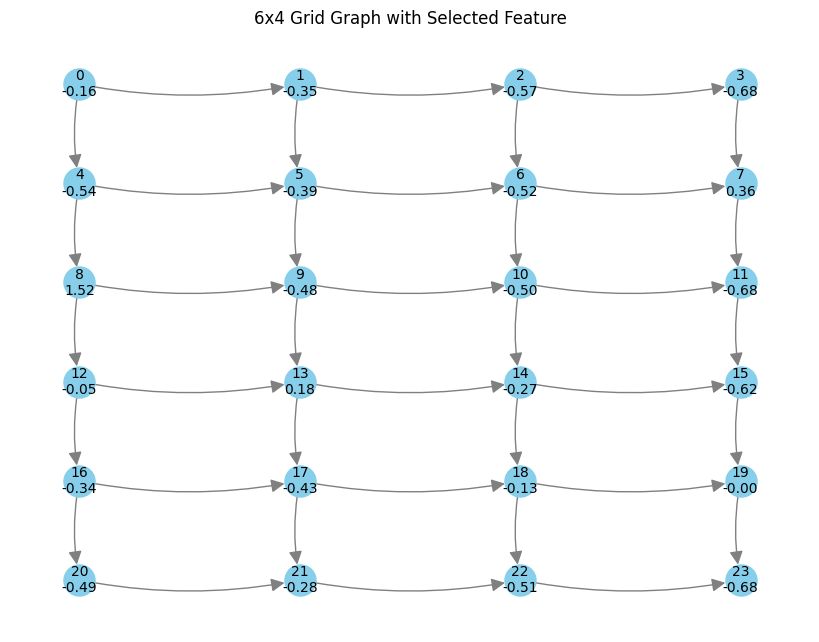

In [ ]:
# 生成邻接矩阵
time_length = 6
bin_length = 4
direct = True  # 设置为 True 表示有向图，设置为 False 表示无向图
adj_matrix = gen_adjmatrix(time_length, bin_length, direct)

# 假设我们有一个 24x6 的特征矩阵
np.random.seed(0)  # 为了可重复性
features = gnn_data[0]

# 绘制图并加上特征值（例如，选择第一个特征值）
# draw_grid_with_features(adj_matrix, time_length, bin_length, features, feature_index=0)

In [32]:
import torch
from new_model.GHAT import PredModel
from config import Config

config = Config()
model = PredModel(config.in_features, config.out_features, config.embed_dim,
                      config.ff_dim, config.n_heads, config.n_nodes, config.n_layers).to(device)
model.load_state_dict(torch.load('./save_models/saved_models/model_best.pt'))

# 生成邻接矩阵
time_length = 6
bin_length = 4
direct = True  # 设置为 True 表示有向图，设置为 False 表示无向图
adj_matrix = gen_adjmatrix(time_length, bin_length, direct)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num = 1000
test_gnn = torch.from_numpy(gnn_data[num]).unsqueeze(0).to(device)
test_lstm = torch.from_numpy(lstm_data[num]).unsqueeze(0).to(device)
adj_matrix = torch.from_numpy(adj_matrix).to(device)
model(test_lstm, test_gnn, adj_matrix)

tensor([[7.5454]], device='cuda:0', grad_fn=<AddBackward0>)

In [33]:
target_data[num]

array([-0.6142,  6.9893, -0.3651, -0.052 , -0.5481, -0.2045,  1.33  ],
      dtype=float32)

In [35]:
import os
os.listdir('./data/0308/0308-data/')

['300433_XSHE_25_daily.csv',
 '000951_XSHE_25_daily.csv',
 '000046_XSHE_25_daily.csv',
 '000998_XSHE_25_daily.csv',
 '002679_XSHE_25_daily.csv',
 '300263_XSHE_25_daily.csv',
 '300540_XSHE_25_daily.csv',
 '603053_XSHG_25_daily.csv',
 '600622_XSHG_25_daily.csv',
 '300174_XSHE_25_daily.csv',
 '002882_XSHE_25_daily.csv',
 '000753_XSHE_25_daily.csv',
 '603359_XSHG_25_daily.csv',
 '300133_XSHE_25_daily.csv',
 '002282_XSHE_25_daily.csv',
 '002841_XSHE_25_daily.csv',
 '300343_XSHE_25_daily.csv',
 '603095_XSHG_25_daily.csv']

In [37]:
import re

# 定义字符串
filename = '300433_XSHE_25_daily.csv'

# 使用正则表达式匹配前面的数字部分
match = re.match(r'^(\d+)', filename).group(1)

In [39]:
int(match)

300433